## Empirical Bayes



**Empirical Bayes** methods are procedures for statistical inference in which the prior distribution is estimated from the data. 

This approach stands in contrast to standard Bayesian methods, for which the prior distribution is fixed before any data are observed. Despite this difference in perspective, empirical Bayes may be viewed as an approximation to a fully Bayesian treatment of a hierarchical model wherein the parameters at the highest level of the hierarchy are set to their most likely values, instead of being integrated out. Empirical Bayes, also known as maximum marginal likelihood, represents one approach for setting hyperparameters. 

### Worked example

**Problem**: With so many features to choose from datasets, how do we prevent making false discoveries?


***Example*** : Suppose you have N betting strategies. Your task is to find strategies whose true winning ratio is above 50%.

Each row describes a strategy.
 - `n_games` describes the number of bets taken with that strategy
 - `won` how many games were won.
 - `ratio` the ratio of games won

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from numpy.random import beta, binomial

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
np.random.seed(42)
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,7)
plt.style.use('bmh')


### Generate data

 - The total number of games is simulated with a uniform distribution.
 - We have 60k strategies.
 - Since the ratio is in [0, 1], we simulate it using beta distribution.
 
 

In [2]:
alpha_reg = 80
beta_reg = 100

alpha_pro = 120
beta_pro = 100

n_games = np.random.randint(low = 50, high=500,size=60000)
ratios = np.append(beta(alpha_reg,beta_reg,size=59500),beta(alpha_pro,beta_pro,size=500))
won = (n_games*ratios).astype(int)
df = pd.DataFrame({'n_games':n_games,'won':won})
df['ratio'] = df.won / df.n_games
df['true'] = ['no'] * 59500 + ['yes'] * 500

df.head()

,n_games,won,ratio,true
0,152,72,0.473684,no
1,485,259,0.534021,no
2,398,181,0.454774,no
3,320,121,0.378125,no
4,156,74,0.474359,no


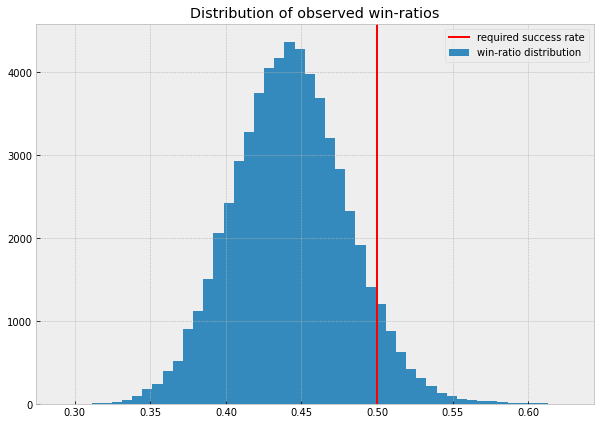

In [3]:
df.ratio.hist(bins=50, label = 'win-ratio distribution')
plt.axvline(x=0.5,c='r',label='required success rate')
plt.legend()
plt.title('Distribution of observed win-ratios');

The problem is that most of the strategies with high win ratios will be there only by chance. We know that most strategies do not have a win-ratio over 0.5. It is clearly evident in our data. We need to find a way to incorporate this indirect evidence into our result.


The key concept is that we are not as only interested in the **distribution of data**, but also in **the distribution about beliefs** about true, unobserved values. The true win-ratio of each strategy is unobserved. But we can form an estimate of what the true win-ratio might be. Because we are not 100% sure about our estimate, we think that multiple true values could be true, but do not assign all of them the same probability of being true.


The key idea behind the **Empricial Bayes method** is to use all of our data to form our prior and then data from specific strategies to form posterior beliefs about the true win-ratios of the different strategies.

In our case, we assume that our belief about a strategies win-ratio can be expressed using a Beta Distribution. This means that we don't think there is one true win-ratio but a distribution of different win ratios. The distribution can be described using two parameters, alpha and beta. We can infer the most likely values to have produced our data using 

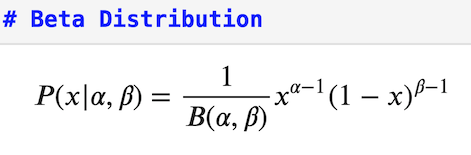

Expected win ratio(distribution mean) under prior: 0.4427


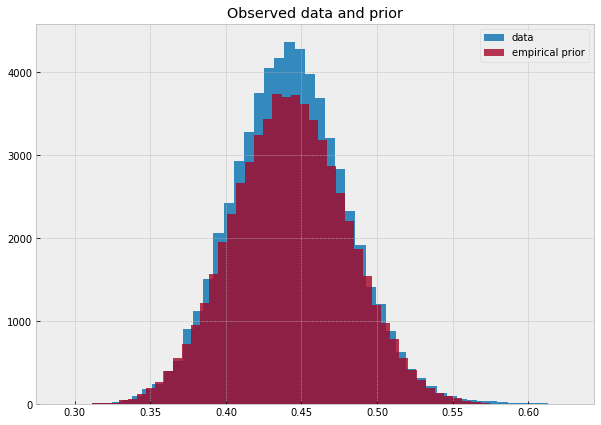

In [4]:
alpha_prior, beta_prior, _, _ = ss.beta.fit(df['ratio'], floc=0, fscale=1)

## Now we can sample from Beta(alpha_prior, beta_prior)



df.ratio.hist(bins=50,label='data')
hist_data = beta(alpha_prior,beta_prior,size=len(df.ratio))
plt.hist(hist_data, histtype='stepfilled',alpha=0.8, bins=50,label='empirical prior')
plt.legend()
plt.title('Observed data and prior');


prior = alpha_prior / (alpha_prior + beta_prior)
print(f'Expected win ratio(distribution mean) under prior: {prior:.4f}')

For beta distributions, the update rule is relatively straightforward. 

The posterior of the alpha parameter equals the number of games won by the strategy plus the prior value of alpha.


The beta parameter equals the number of games lost by the strategy plus the beta prior.

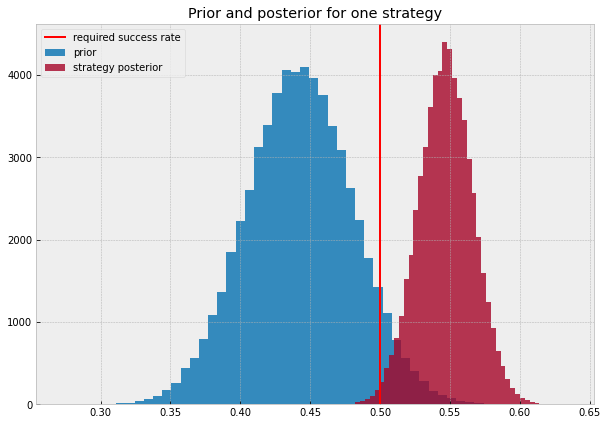

In [5]:
df['alpha_posterior'] = df.won + alpha_prior
df['beta_posterior'] = (df.n_games - df.won) + beta_prior



plt.hist(beta(alpha_prior,beta_prior,size=len(df.ratio)),histtype='stepfilled', bins=50, label='prior')
plt.hist(beta(df.alpha_posterior[59901],df.beta_posterior[59901],
              size=len(df.ratio)),histtype='stepfilled', bins=50, alpha=0.8,label='strategy posterior')
plt.axvline(x=0.5,c='r',label='required success rate')
plt.legend()
plt.title('Prior and posterior for one strategy');


### Shrinkage

Because we take the overall mean win-ratio into account when estimating the true win ratio of each strategy, we "shrink" our estimates towards the grand-mean. 
Empirical Bayes is a so called "shrinkage" method. As we will see later this is precisely what helps us to reduce false discoveries: We bias our estimates towards finding nothing.

To visualize the shrinkage, let's calculate the mean posterior win ratio for each strategy:

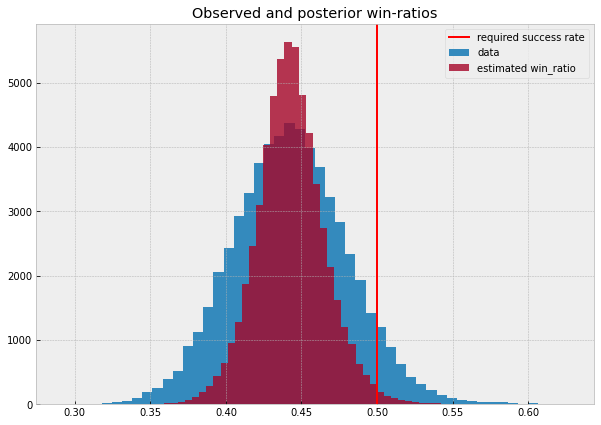

In [6]:
df['eb_ratio'] = df.alpha_posterior / (df.alpha_posterior + df.beta_posterior)


df.ratio.hist(bins=50, label='data');
df.eb_ratio.hist(bins=50,alpha=0.8,label='estimated win_ratio');
plt.axvline(x=0.5,c='r',label='required success rate')
plt.legend()
plt.title('Observed and posterior win-ratios');

### False Discovery Rates

As we saw earlier, we do not only estimate one true win-ratio for each strategy. We estimate an entire distribution of win-ratios we deem possible. 

This simplifies the problem : "How likely is it that the strategy is a false discovery, and the true win-ratio is below 0.5?"

To answer this, we can ask ourselves: "What share of our posterior belief distribution for our strategy is below 0.5?"

The chart below shows the posterior belief distribution of a strategy. The red line is the critical hurdle of 0.5. The orange area shows the part of the belief distribution that is below the hurdle. Under our belief, the probability that the true win-ratio is less than 0.5 is the orange area.


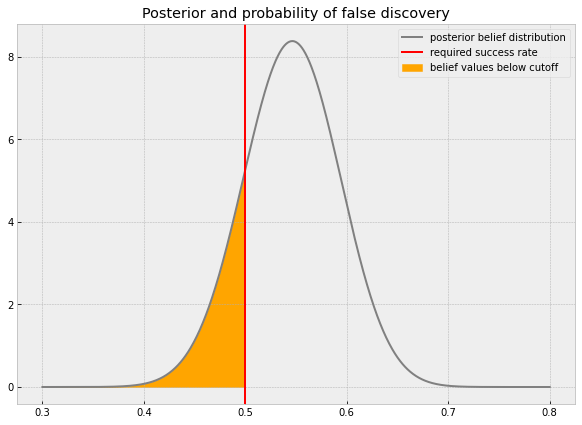

In [7]:
t_values = np.linspace(0.3, 0.8, 1000)
pdf_values = ss.beta.pdf(t_values,60,50)

plt.plot(t_values, pdf_values, color='grey', label='posterior belief distribution')
plt.fill_between(t_values, pdf_values,
                        where=t_values <= 0.5,color='orange',label='belief values below cutoff')

plt.axvline(x=0.5,c='r',label='required success rate')
plt.legend()
plt.title('Posterior and probability of false discovery');

This method can be applied to all strategies to find out the likehood that they are a false discovery:

In [18]:
df['FDR'] = ss.beta.cdf(0.5,df.alpha_posterior,df.beta_posterior)

df = df.sort_values('FDR')
df.head(5)

,n_games,won,ratio,true,alpha_posterior,beta_posterior,eb_ratio,FDR
59512,434,272,0.626728,yes,346.88018,256.259248,0.575124,0.000108
59829,482,296,0.614108,yes,370.88018,280.259248,0.569586,0.000186
59581,467,287,0.614561,yes,361.88018,274.259248,0.568869,0.000249
59545,464,284,0.612069,yes,358.88018,274.259248,0.566826,0.000375
59637,397,246,0.619647,yes,320.88018,245.259248,0.566786,0.000723


In [21]:
accepted = df[df.FDR.cumsum() < 0.05]
print(f"The actual false discovery rate is {(len(accepted[accepted.true == 'no']) / len(accepted)*100):.2f}%")

The actual false discovery rate is 5.26%


## References

1. Taken from https://github.com/JannesKlaas/sometimes_deep_sometimes_learning/blob/master/Empirical%20Bayes.ipynb
2. https://vasishth.github.io/bayescogsci/book/sec-analytical.html